In [2]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler

# --- Load Model dan Scaler ---
xgb_model = joblib.load('xgb_model.pkl')          
scaler = joblib.load('scaler.pkl')                     

# --- Load Data IoT ---
try:
    IOT_data = pd.read_csv('ALL_DAY.csv')
    print(f"File 'ALL_DAY.csv' berhasil dibaca. Shape: {IOT_data.shape}")
except FileNotFoundError:
    print("File tidak ditemukan.")
    exit()

# --- Siapkan Fitur dan Scaling ---
X_features = ['temperature', 'humidity', 'air_flow', 'mrt']

if not all(feat in IOT_data.columns for feat in X_features):
    print("Error: Kolom fitur tidak lengkap dalam data.")
    exit()

X_raw = IOT_data[X_features]
X_scaled = scaler.transform(X_raw)

# --- Prediksi PMV dengan Model XGBoost ---
predicted_pmv = xgb_model.predict(X_scaled)
IOT_data['pmv'] = np.round(predicted_pmv, 4)

# --- Simpan Hasil (Opsional) ---
IOT_data.to_csv('ALL_DAY_XGB_PREDICTED.csv', index=False)
print("Nilai PMV berhasil diganti menggunakan model XGBoost.")

File 'ALL_DAY.csv' berhasil dibaca. Shape: (1451, 8)
Nilai PMV berhasil diganti menggunakan model XGBoost.


In [4]:
import pandas as pd
import numpy as np
from pythermalcomfort.models import pmv_ppd_ashrae
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Load Data Gabungan ---
try:
    IOT_data_full = pd.read_csv('ALL_DAY_XGB_PREDICTED.csv')
    print(f"File 'ALL_DAY_XGB_PREDICTED.csv' berhasil dibaca. Shape: {IOT_data_full.shape}")
except FileNotFoundError:
    print("Error: File tidak ditemukan.")
    exit()

# --- Hitung PMV Aktual ---
def calculate_actual_pmv(row):
    try:
        tdb = float(row['temperature'])
        tr = float(row['mrt'])
        vr = float(row['air_flow'])
        rh = float(row['humidity'])
        met = 1.2
        clo = 0.5
        if not (10 <= tdb <= 50) or not (10 <= tr <= 50): return np.nan
        if not (0 <= rh <= 100): return np.nan
        if vr == 0: vr = 0.01
        pmv_result = pmv_ppd_ashrae(tdb=tdb, tr=tr, vr=vr, rh=rh, met=met, clo=clo)
        return round(pmv_result['pmv'], 4)
    except:
        return np.nan

print("Menghitung PMV Aktual...")
IOT_data_full['pmv_aktual'] = IOT_data_full.apply(calculate_actual_pmv, axis=1)
IOT_data_full.dropna(subset=['pmv', 'pmv_aktual'], inplace=True)
print(f"Selesai hitung PMV Aktual. Shape setelah dropna: {IOT_data_full.shape}")

# === EVALUASI GABUNGAN ===
y_true_combined = IOT_data_full['pmv_aktual']
y_pred_combined = IOT_data_full['pmv']
print(f"\nGabungan Hari 1 & 2")
print(f"Jumlah Data: {len(y_true_combined)}")
print(f"MAE : {mean_absolute_error(y_true_combined, y_pred_combined):.4f}")
print(f"RMSE: {mean_squared_error(y_true_combined, y_pred_combined, squared=False):.4f}")
print(f"R²  : {r2_score(y_true_combined, y_pred_combined):.4f}")

# === PEMISAHAN HARI 1 dan HARI 2 ===
IOT_day1_df = IOT_data_full.iloc[1:734].reset_index(drop=True)
IOT_day2_df = IOT_data_full.iloc[734:1452].reset_index(drop=True)

# Simpan (opsional)
IOT_day1_df.to_csv('IOT_DAY1_PROCESSED.csv', index=False)
IOT_day2_df.to_csv('IOT_DAY2_PROCESSED.csv', index=False)

# === EVALUASI HARI 1 ===
y_true_day1 = IOT_day1_df['pmv_aktual']
y_pred_day1 = IOT_day1_df['pmv']
print(f"\nHari 1: Ruang Tunggu Eksekutif (AC ON)")
print(f"Jumlah Data: {len(y_true_day1)}")
print(f"MAE : {mean_absolute_error(y_true_day1, y_pred_day1):.4f}")
print(f"RMSE: {mean_squared_error(y_true_day1, y_pred_day1, squared=False):.4f}")
print(f"R²  : {r2_score(y_true_day1, y_pred_day1):.4f}")

# === EVALUASI HARI 2 ===
y_true_day2 = IOT_day2_df['pmv_aktual']
y_pred_day2 = IOT_day2_df['pmv']
print(f"\nHari 2: Ruang Tunggu Umum (AC OFF)")
print(f"Jumlah Data: {len(y_true_day2)}")
print(f"MAE : {mean_absolute_error(y_true_day2, y_pred_day2):.4f}")
print(f"RMSE: {mean_squared_error(y_true_day2, y_pred_day2, squared=False):.4f}")
print(f"R²  : {r2_score(y_true_day2, y_pred_day2):.4f}")


File 'ALL_DAY_XGB_PREDICTED.csv' berhasil dibaca. Shape: (1451, 8)
Menghitung PMV Aktual...


c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2360: UserWarning: Cooling effect could not be calculated. Returning 0.
  return self.pyfunc(*the_args, **kwargs)
c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2360: UserWarning: Cooling effect could not be calculated. Returning 0.
  return self.pyfunc(*the_args, **kwargs)
c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2360: UserWarning: Cooling effect could not be calculated. Returning 0.
  return self.pyfunc(*the_args, **kwargs)
c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2360: UserWarning: Cooling effect could not be calculated. Returning 0.
  return self.pyfunc(*the_args, **kwargs)
c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2360: UserWarning: Cooling effect could not be ca

Selesai hitung PMV Aktual. Shape setelah dropna: (1451, 9)

Gabungan Hari 1 & 2
Jumlah Data: 1451
MAE : 0.0586
RMSE: 0.0799
R²  : 0.9947

Hari 1: Ruang Tunggu Eksekutif (AC ON)
Jumlah Data: 733
MAE : 0.0462
RMSE: 0.0580
R²  : 0.9394

Hari 2: Ruang Tunggu Umum (AC OFF)
Jumlah Data: 717
MAE : 0.0713
RMSE: 0.0973
R²  : 0.8664


c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2360: UserWarning: Cooling effect could not be calculated. Returning 0.
  return self.pyfunc(*the_args, **kwargs)
c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2360: UserWarning: Cooling effect could not be calculated. Returning 0.
  return self.pyfunc(*the_args, **kwargs)
C:\Users\acer\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\acer\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\ace

In [1]:
import numpy as np

def hitung_ppd_dari_pmv(pmv):
  ppd = 100.0 - 95.0 * np.exp(-0.03353 * pmv**4 - 0.2179 * pmv**2)
  return round(ppd, 2)

# --- Hitung PPD --
# PMV rata-rata dari Ruang Tunggu Eksekutif (AC ON)
pmv_eksekutif = -0.70
ppd_eksekutif = hitung_ppd_dari_pmv(pmv_eksekutif)

# PMV rata-rata dari Ruang Tunggu Umum (AC OFF)
pmv_umum = 1.32
ppd_umum = hitung_ppd_dari_pmv(pmv_umum)

print(f"Untuk PMV = {pmv_eksekutif}, PPD yang diestimasi adalah: {ppd_eksekutif}%")
print(f"Untuk PMV = {pmv_umum}, PPD yang diestimasi adalah: {ppd_umum}%")

Untuk PMV = -0.7, PPD yang diestimasi adalah: 15.31%
Untuk PMV = 1.32, PPD yang diestimasi adalah: 41.3%


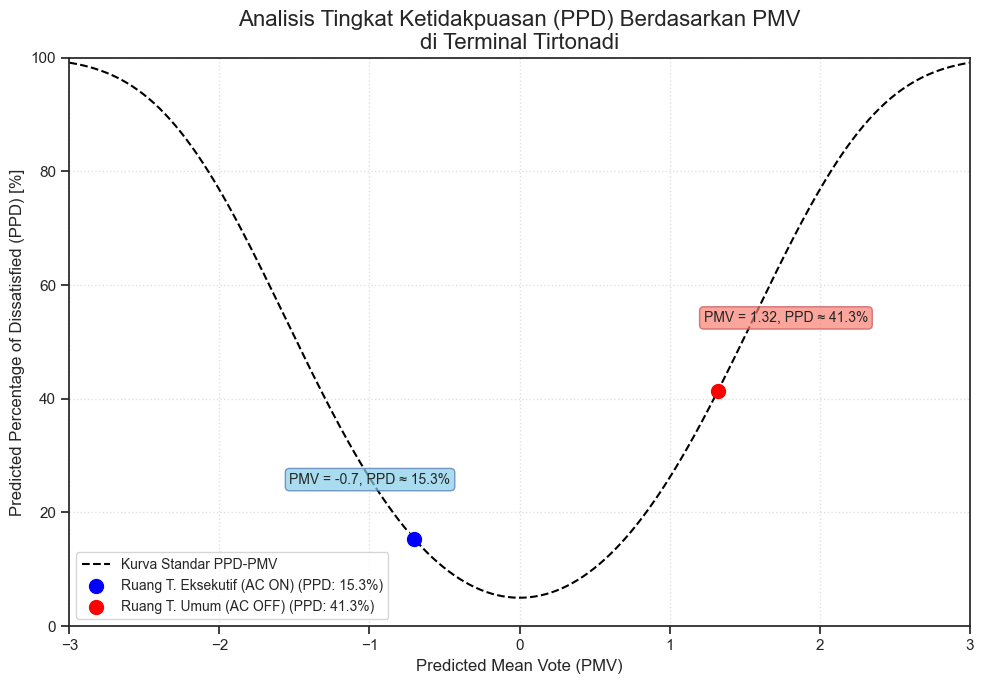

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Atur style plot
sns.set_theme(style="ticks")

def hitung_ppd_dari_pmv(pmv):
  """Fungsi untuk menghitung PPD dari PMV."""
  return 100.0 - 95.0 * np.exp(-0.03353 * pmv**4 - 0.2179 * pmv**2)

# --- 1. Membuat data untuk kurva PPD vs PMV ---
pmv_range = np.linspace(-3, 3, 500)
# Hitung nilai PPD untuk setiap PMV dalam rentang tersebut
ppd_curve = hitung_ppd_dari_pmv(pmv_range)

# --- 2. Data titik spesifik dari penelitian Anda ---
pmv_points = [-0.70, 1.32]
ppd_points = [hitung_ppd_dari_pmv(p) for p in pmv_points]
labels = ['Ruang T. Eksekutif (AC ON)', 'Ruang T. Umum (AC OFF)']
colors = ['blue', 'red']

# --- 3. Membuat Grafik ---
plt.figure(figsize=(10, 7))

# Plot kurva utama PPD vs PMV
plt.plot(pmv_range, ppd_curve, color='black', linestyle='--', label='Kurva Standar PPD-PMV')

# Plot titik-titik hasil 
for i in range(len(pmv_points)):
    plt.scatter(pmv_points[i], ppd_points[i], color=colors[i], s=100, zorder=5, label=f'{labels[i]} (PPD: {ppd_points[i]:.1f}%)')

# Menambahkan anotasi/teks pada plot
plt.annotate(
    f'PMV = {pmv_points[0]}, PPD ≈ {ppd_points[0]:.1f}%',
    xy=(pmv_points[0], ppd_points[0]),
    xytext=(-90, 40),
    textcoords='offset points',
    arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"),
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.3", fc="skyblue", ec="b", lw=1, alpha=0.7)
)
plt.annotate(
    f'PMV = {pmv_points[1]}, PPD ≈ {ppd_points[1]:.1f}%',
    xy=(pmv_points[1], ppd_points[1]),
    xytext=(-10, 50),
    textcoords='offset points',
    arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-.2"),
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.3", fc="salmon", ec="r", lw=1, alpha=0.7)
)

# --- 4. Judul dan Label ---
plt.title('Analisis Tingkat Ketidakpuasan (PPD) Berdasarkan PMV\ndi Terminal Tirtonadi', fontsize=16)
plt.xlabel('Predicted Mean Vote (PMV)', fontsize=12)
plt.ylabel('Predicted Percentage of Dissatisfied (PPD) [%]', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(fontsize=10)

# PERUBAHAN: Atur batas sumbu X dan Y 
plt.xlim(-3, 3)
plt.ylim(0, 100)

# Tampilkan plot
plt.tight_layout()
plt.show()

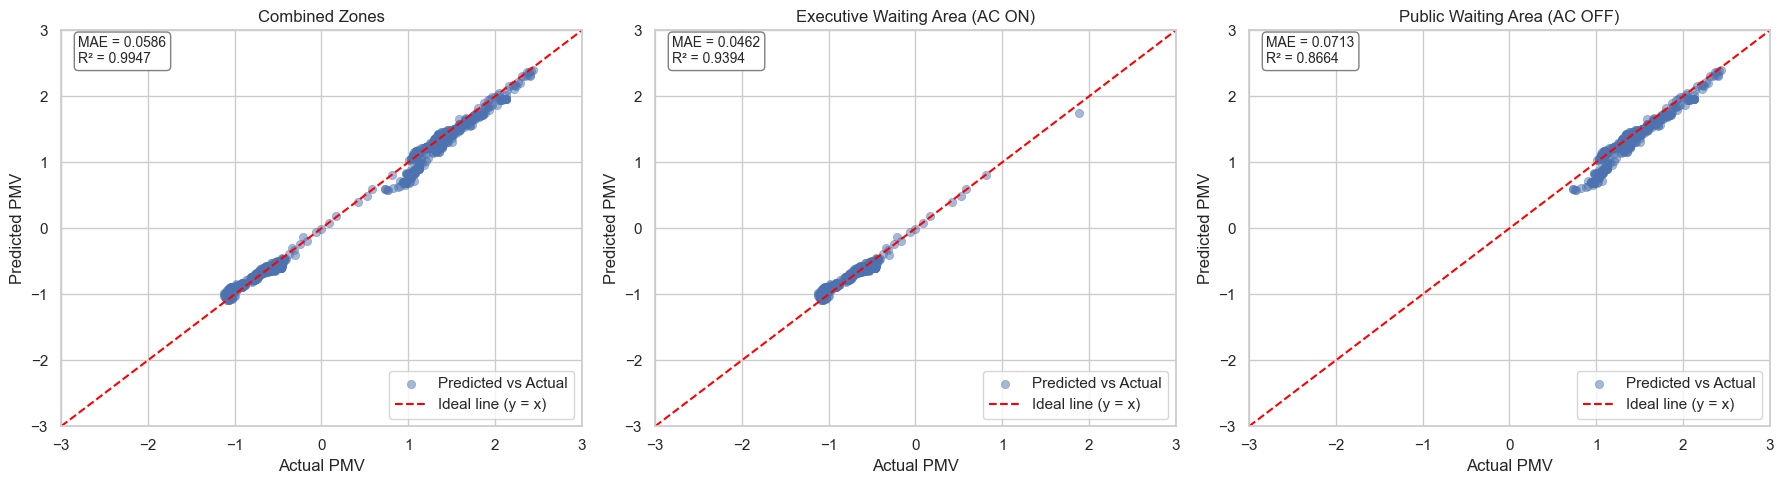

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score

sns.set(style="whitegrid")

# === Fungsi untuk membuat scatter plot dengan tambahan info ===
def plot_scatter_with_line(y_true, y_pred, title, ax):
    # Scatter plot
    sns.scatterplot(x=y_true, y=y_pred, ax=ax, alpha=0.5, edgecolor=None, label='Predicted vs Actual')

    # Garis ideal y = x
    ax.plot([-3, 3], [-3, 3], color='red', linestyle='--', label='Ideal line (y = x)')


    # Batas dan label
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_xlabel('Actual PMV')
    ax.set_ylabel('Predicted PMV')
    ax.set_title(title)

    # Hitung metrik evaluasi
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Tampilkan MAE dan R² di plot
    ax.text(-2.8, 2.5, f"MAE = {mae:.4f}\nR² = {r2:.4f}", fontsize=10,
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round'))

    ax.legend()

# === Plot semua zona dalam 1 row ===
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gabungan Hari 1 & 2
plot_scatter_with_line(
    IOT_data_full['pmv_aktual'], 
    IOT_data_full['pmv'], 
    "Combined Zones", 
    axes[0]
)  

# Hari 1: Eksekutif
plot_scatter_with_line(
    IOT_day1_df['pmv_aktual'], 
    IOT_day1_df['pmv'], 
    "Executive Waiting Area (AC ON)", 
    axes[1]
)

# Hari 2: Umum
plot_scatter_with_line(
    IOT_day2_df['pmv_aktual'], 
    IOT_day2_df['pmv'], 
    "Public Waiting Area (AC OFF)", 
    axes[2]
)

plt.tight_layout()
plt.savefig("scatter_pmv_predictions_enhanced.png", dpi=300)
plt.show()
